In [94]:
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import os
import pandas as pd
import re

In [95]:
def to_k(y, pos):
  return '%1.0fk' % (y * 1e-3)

In [96]:
datasets = ['books', 'history', 'fb', 'osm']
# colors = ['#4E79A7', '#F28E2B', '#59A14F', '#E15759']
colors = ['red', 'orange', 'green', 'blue']

build_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'build')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

/tmp/ipykernel_1202346/3723961641.py:7: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, header=None)
/tmp/ipykernel_1202346/3723961641.py:7: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, header=None)
/tmp/ipykernel_1202346/3723961641.py:7: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, header=None)
/tmp/ipykernel_1202346/3723961641.py:7: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, header=None)


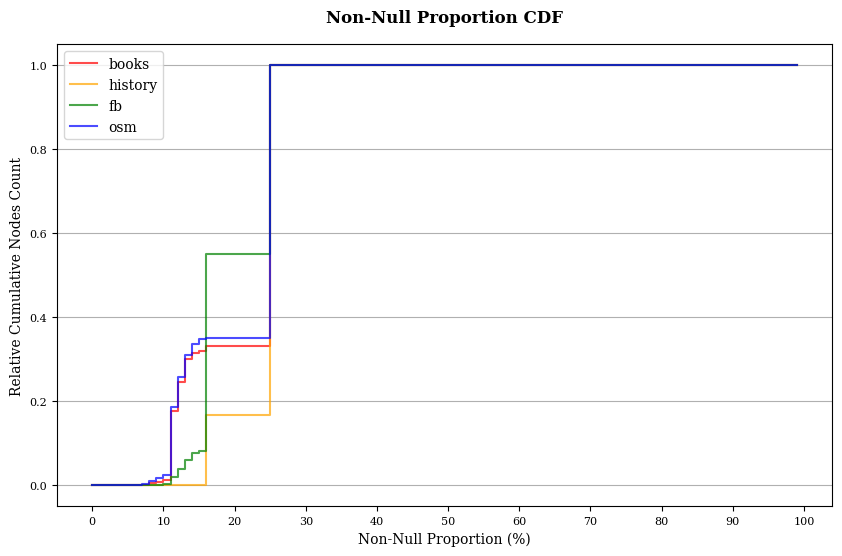

In [97]:
csv_file_names = [os.path.join(build_path, f'{dataset}.csv') for dataset in datasets]

plt.figure(figsize=(10, 6))

for i, file_name in enumerate(csv_file_names):
    try:
      df = pd.read_csv(file_name, header=None)
    except Exception as e:
      continue

    total_count = len(df)
    total_values = df.iloc[2:, 0].astype(float)
    null_values = df.iloc[2:, 1].astype(float)
    non_null_percentages = ((total_values - null_values) / total_values) * 100
    percent_intervals = np.arange(0, 101, 1)
    counts, _ = np.histogram(non_null_percentages, bins=percent_intervals)
    counts = np.asarray(counts) / total_count
    cumulative_counts = np.cumsum(counts)

    plt.plot(percent_intervals[:-1], cumulative_counts,
             drawstyle='steps-post', color=colors[i % len(colors)], alpha=0.7, label=file_name.split('/')[-1].split('.')[0])

plt.xlabel('Non-Null Proportion (%)', fontdict={'weight': 'bold'})
plt.ylabel('Relative Cumulative Nodes Count', fontdict={'weight': 'bold'})
plt.xticks(np.arange(0, 101, 10), size=8)
plt.yticks(size=8)
plt.grid(axis='y')
plt.legend()
plt.title('Non-Null Proportion CDF', fontdict={'size': 12, 'weight': 'bold'}, pad=16)
plt.show()

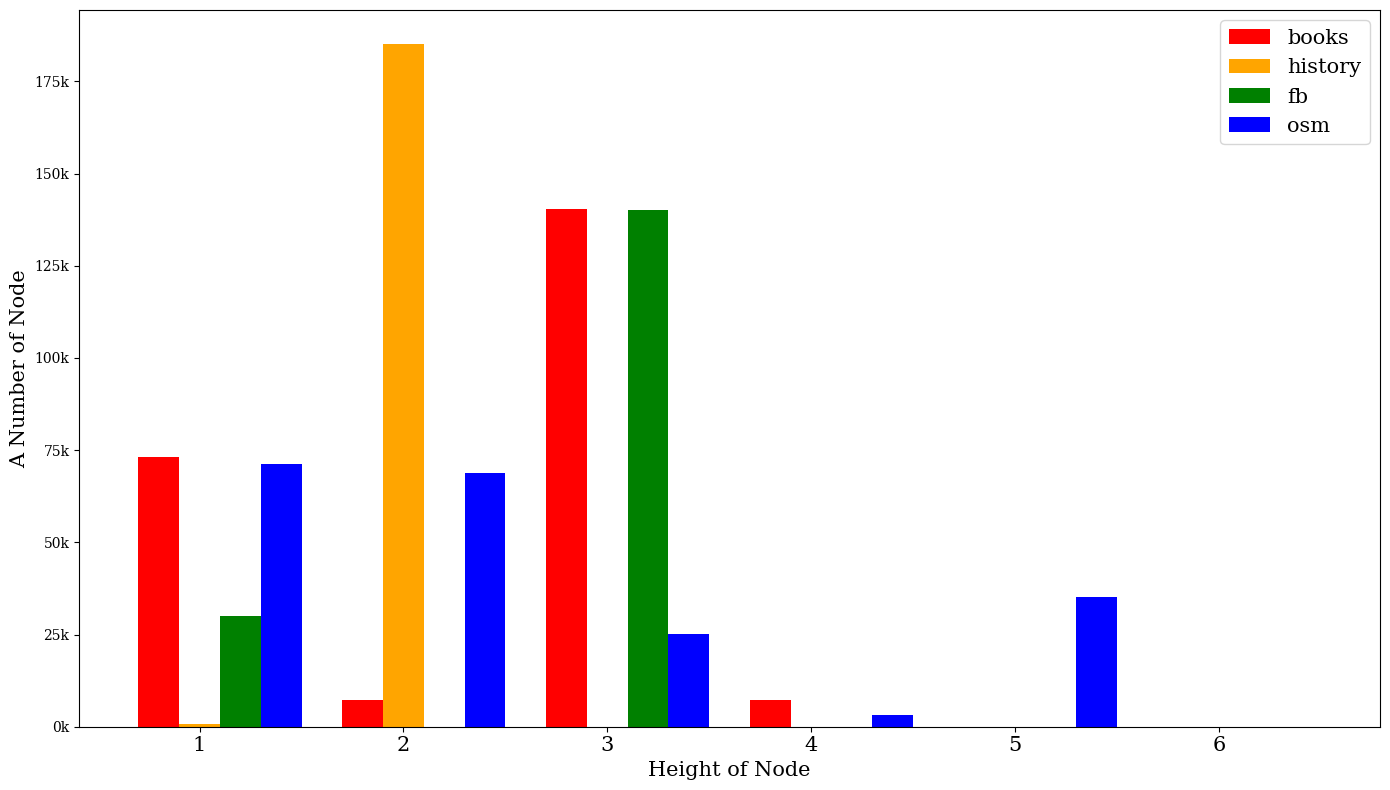

In [98]:
csv_file_names = [os.path.join(build_path, f'{dataset}.csv') for dataset in datasets]

# 각 파일의 데이터를 저장할 빈 DataFrame 생성
df_combined = pd.DataFrame()

# 각 파일에 대해 반복하여 데이터 처리
for i, file_name in enumerate(csv_file_names):
    df = pd.read_csv(file_name)
    # 'height' 별로 개수를 계산하고 DataFrame으로 변환
    height_counts = df['height'].value_counts().sort_index().rename_axis('height').reset_index(name=f'counts_{i}')
    # 병합된 DataFrame에 추가
    if df_combined.empty:
        df_combined = height_counts
    else:
        df_combined = pd.merge(df_combined, height_counts, on='height', how='outer')

# NaN 값을 0으로 채움
df_combined.fillna(0, inplace=True)

# 그래프 그리기
plt.figure(figsize=(14, 8))
bar_width = 0.2  # 막대 너비
indices = np.arange(len(df_combined['height']))  # height 값의 개수에 따른 인덱스 배열

for i in range(len(csv_file_names)):
    plt.bar(indices + i * bar_width, df_combined[f'counts_{i}'], width=bar_width, color=colors[i], label=datasets[i])

plt.xlabel('Height of Node', fontsize=15)
plt.ylabel('A Number of Node', fontsize=15)
plt.title('', fontsize=15, fontweight='bold')
plt.xticks(indices + bar_width, df_combined['height'], fontsize=15)

# y축 값을 K 단위로 설정
formatter = FuncFormatter(to_k)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(fontsize=15)
plt.tight_layout()
plt.show()


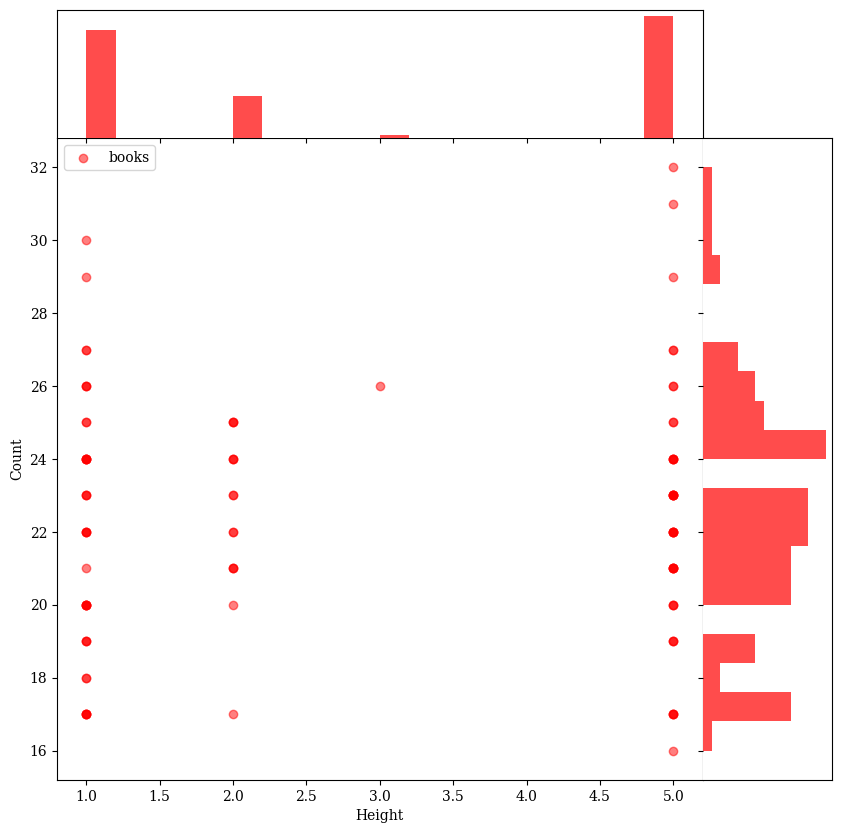

In [99]:
datasets = ['books']
csv_file_names = [os.path.join(build_path, f'{dataset}_count.csv') for dataset in datasets]

dataframes = []

# 각 파일에 대해 반복하여 데이터 처리
for file_name in csv_file_names:
    data = pd.read_csv(file_name)
    dataframes.append(data)

fig = plt.figure(figsize=(10, 10))

# Create a gridspec for a 2x2 grid
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0, width_ratios=[5, 1], height_ratios=[1, 5])

# Add a scatter subplot on the left bottom
scatter_ax = fig.add_subplot(gs[1, 0])

# Add histograms to the top and right of the scatter plot
hist_x_ax = fig.add_subplot(gs[0, 0], sharex=scatter_ax)
hist_y_ax = fig.add_subplot(gs[1, 1], sharey=scatter_ax)

# Hide the spines between the scatter and histograms
hist_x_ax.spines['bottom'].set_visible(False)
hist_y_ax.spines['left'].set_visible(False)

# Hide the ticks on the histograms that overlap with the scatter plot
plt.setp(hist_x_ax.get_xticklabels(), visible=False)
plt.setp(hist_y_ax.get_yticklabels(), visible=False)

for i, dataframe in enumerate(dataframes):
    # Scatter plot
    scatter_ax.scatter(dataframe['height'], dataframe['count'], alpha=0.5, color=colors[i], label=datasets[i])
    
    # Histogram for x-axis data
    hist_x_ax.hist(dataframe['height'], bins=20, alpha=0.7, color=colors[i])

    # Histogram for y-axis data
    hist_y_ax.hist(dataframe['count'], bins=20, orientation='horizontal', alpha=0.7, color=colors[i])

# Make the histograms share the same y-axis with the scatter plot
hist_x_ax.set(yticklabels=[], yticks=[])
hist_y_ax.set(xticklabels=[], xticks=[])

scatter_ax.legend()
scatter_ax.set_xlabel('Height')
scatter_ax.set_ylabel('Count')

plt.show()